In [2]:
import numpy as np
import PIL.Image
import glob
import os

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])
DATASET_PATH = "./dataset_rot/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = next(os.walk(DATASET_PATH))[1]

print(DATASET_PATH)
print(CLASSES)


/tmp/deepl/dataset_rot
['octane', 'werewolf', 'breakout', 'aftershock']


In [4]:
def load_data():
    # Récupération des fichiers
    files = glob.glob(f"{DATASET_PATH}/**/*.jpg", recursive=True)

    # Initialise les structures de données
    x = np.zeros((len(files), *RESIZED_SIZE_PIL))
    y = np.zeros((len(files), 1))

    # print(f"x.shape = {x.shape}")

    for i, path in enumerate(files):
        # Lecture de l'image
        img = PIL.Image.open(path)

        # print(f"img.size = {img.size}")

        # Redimensionnement de l'image
        img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)

        # print(f"img.size = {img.size}")

        test = np.asarray(img)

        # print(f"test.shape = {test.shape}")

        # Remplissage de la variable x
        x[i] = test

        # On récupère l'index dans le path
        class_label = path.split("/")[-2]

        # On récupère le numéro de la classe à partir du string
        class_label = CLASSES.index(class_label)

        # Remplissage de la variable y
        y[i] = class_label

    return x, y


In [5]:
x, y = load_data()
x = x / 255


/tmp/ipykernel_895883/2192415425.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize(RESIZED_SIZE[:-1], PIL.Image.ANTIALIAS)


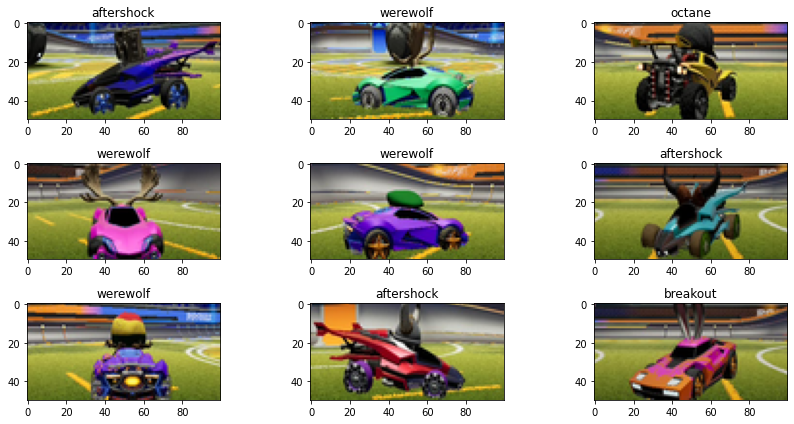

In [6]:
# Randomisation des indices et affichage de 9 images alétoires de la base d'apprentissage
indices = np.arange(x.shape[0])
np.random.shuffle(indices)

plt.figure(figsize=(12, 6))

for i in range(0, 3 * 3):
    plt.subplot(3, 3, i + 1)
    plt.title(CLASSES[int(y[indices[i]])])
    plt.imshow(x[indices[i]])

plt.tight_layout()
plt.show()


In [7]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers


In [23]:
model = Sequential()

model.add(InputLayer(input_shape=RESIZED_SIZE_PIL))

model.add(Conv2D(32, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(92, 3, activation="relu", name="conv2d_last"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(250, activation="relu"))

model.add(Dense(4, activation="softmax"))

model.summary()

adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(x, y, validation_split=0.15, epochs=5)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 98, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 49, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 47, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 11, 23, 64)       0         
 2D)                                                             
                                                                 
 conv2d_last (Conv2D)        (None, 9, 21, 92)         53084     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 10, 92)       

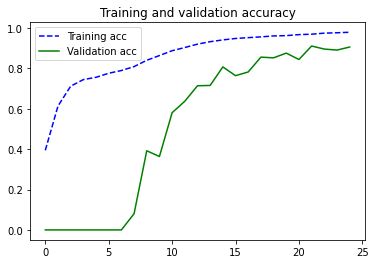

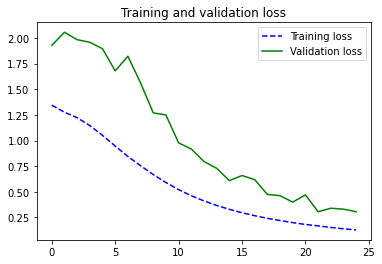

In [24]:
def plot_training_analysis():
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.plot(epochs, acc, "b", linestyle="--", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "b", linestyle="--", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()


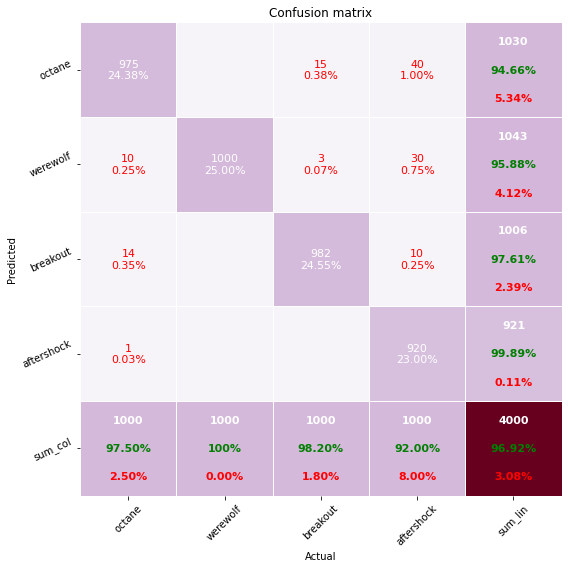

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from pretty_confusion_matrix import pp_matrix

prediction = model.predict(x)
prediction = np.argmax(prediction, axis=1)
res = tensorflow.math.confusion_matrix(y, prediction)

# get pandas dataframe
df_cm = pd.DataFrame(res, CLASSES, CLASSES)

# colormap: see this and choose your more dear
cmap = 'PuRd'

# pretty_confusion_matrix
pp_matrix(df_cm, cmap=cmap)

In [27]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


(50, 100, 3)


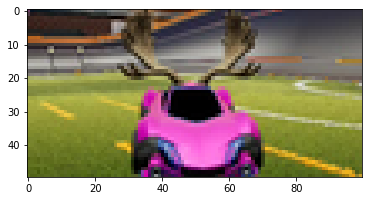

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm

model_builder = keras.applications.xception.Xception
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "conv2d_last"

img = x[indices[3]]

plt.imshow(img)
print(img.shape)

Model detected : werewolf


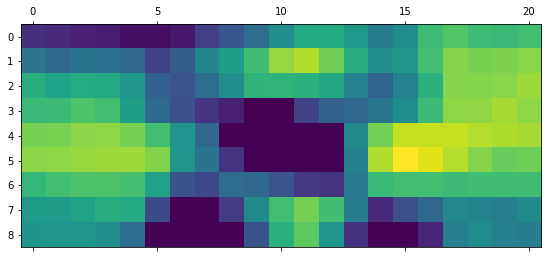

In [72]:
# Remove last layer's softmax
model.layers[-1].activation = None

X = np.zeros((1, RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2]))
X[0] = np.asarray(img)

# Print what the top predicted class is
preds = model.predict(X)
index = np.argmax(preds)
LABELS = ["octane", "werewolf", "breakout", "aftershock"]
print(f"Model detected : {LABELS[index]}")

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(X, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


Model detected : aftershock
Model detected : octane
Model detected : werewolf
Model detected : werewolf
Model detected : breakout
Model detected : werewolf
Model detected : octane
Model detected : octane
Model detected : breakout
Model detected : octane


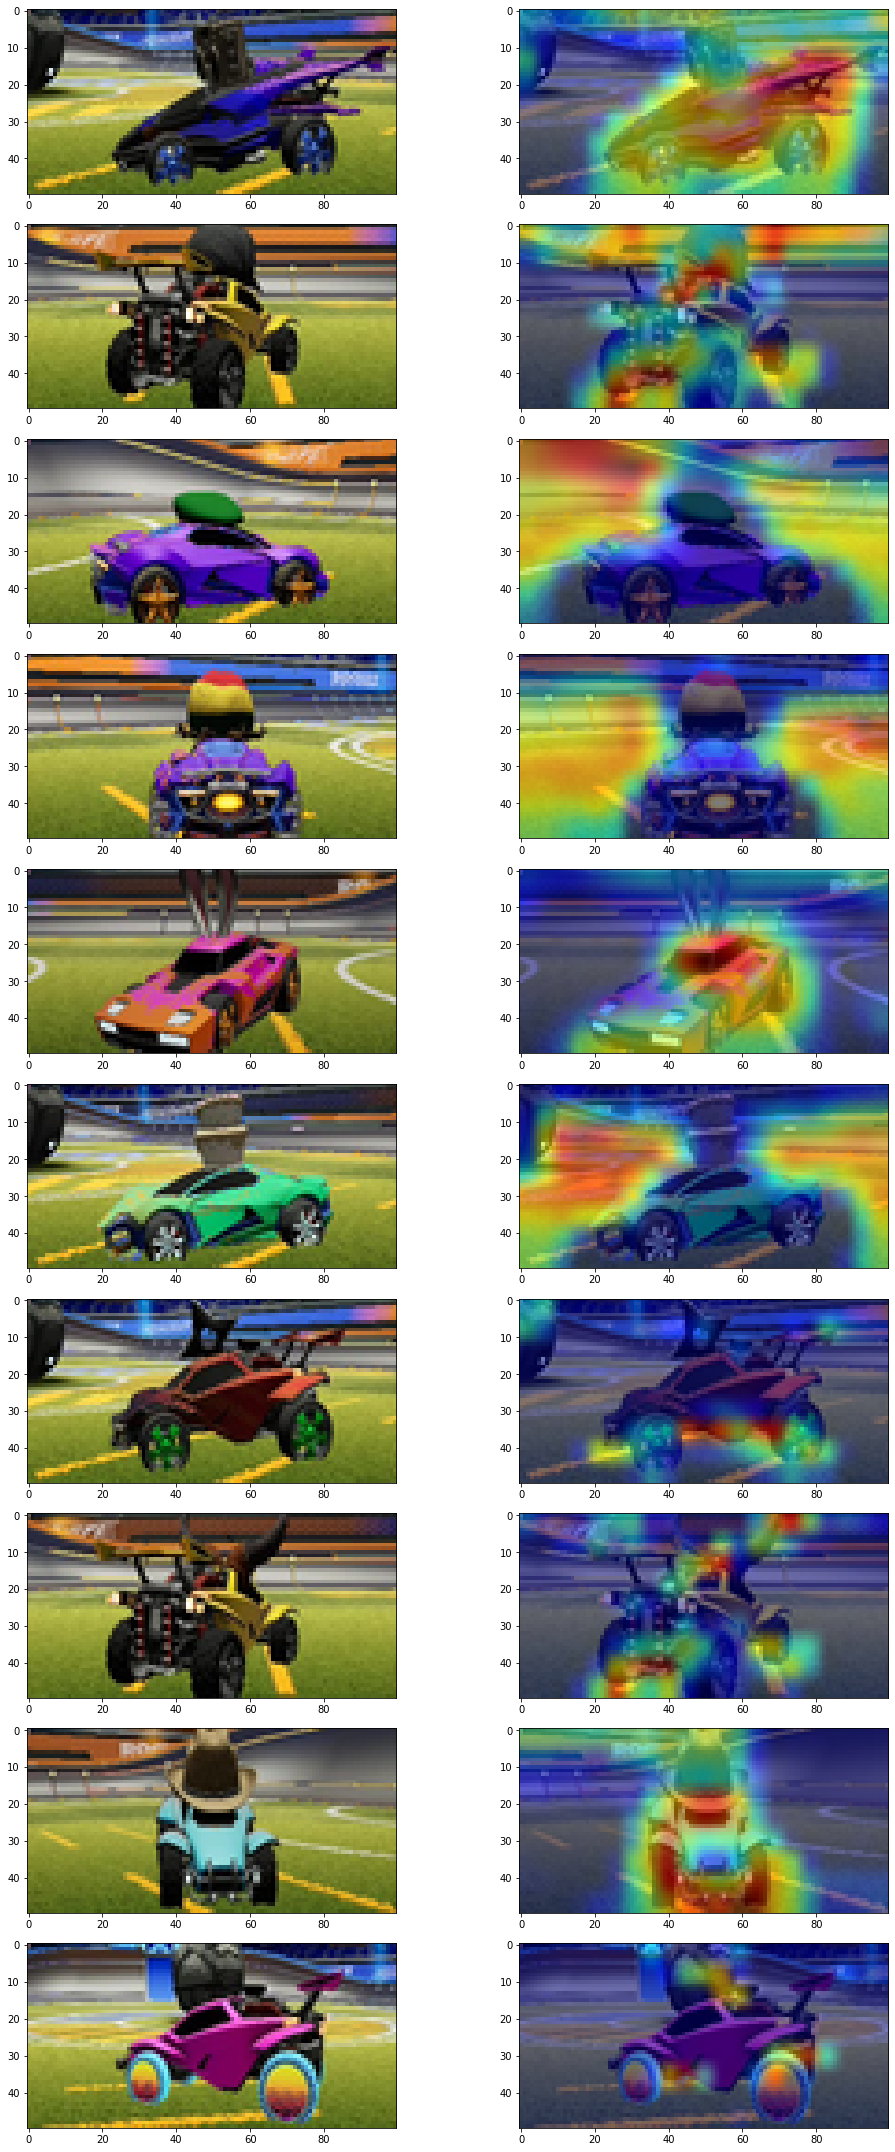

In [78]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img

plt.figure(figsize=(15, 30))

for i in range(0, 10 * 2, 2):

    img = x[indices[i]]

    X = np.zeros((1, RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2]))
    X[0] = np.asarray(img)

    # Print what the top predicted class is
    preds = model.predict(X)
    index = np.argmax(preds)
    LABELS = ["octane", "werewolf", "breakout", "aftershock"]
    print(f"Model detected : {LABELS[index]}")

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(X, model, last_conv_layer_name)

    tmp = save_and_display_gradcam(img, heatmap, alpha=0.004)

    plt.subplot(10, 2, i+1)
    plt.imshow(img)
    plt.subplot(10, 2, i+2)
    plt.imshow(tmp)

plt.tight_layout()
plt.show()


In [ ]:
IMAGE_SIZE = (400, 150, 3)
RESIZED_SIZE = (100, 50, 3)
RESIZED_SIZE_PIL = (RESIZED_SIZE[1], RESIZED_SIZE[0], RESIZED_SIZE[2])
DATASET_PATH = "./data/"
DATASET_PATH = os.path.abspath(DATASET_PATH)
CLASSES = next(os.walk(DATASET_PATH))[1]

print(DATASET_PATH)
print(CLASSES)


In [ ]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import sqlite3

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
SHUFFLE_SIZE = 32
LIMIT = 10000


def customGenerator():
    data = (
        sqlite3.connect(f"{DATASET_PATH}/index.db")
        .execute(f"SELECT uuid, model from data order by random() LIMIT {LIMIT}")
        .fetchall()
    )

    for uuid, model in data:
        img = tf.io.read_file(f"{DATASET_PATH}/{uuid}.jpg")
        img = tf.image.decode_jpeg(img, channels=IMAGE_SIZE[2])
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, RESIZED_SIZE[:-1])

        label = tf.convert_to_tensor(model, dtype=tf.uint8)

        yield img, label


def cutout(image, label):
    img = tfa.image.random_cutout(image, (6, 6), constant_values=1)
    return (img, label)


def rotate(image, label):
    img = tfa.image.rotate(image, tf.constant(np.pi))
    return (img, label)


def set_shapes(image, label):
    image.set_shape(RESIZED_SIZE)
    label.set_shape([])
    return image, label


dataset = tf.data.Dataset.from_generator(generator=customGenerator, output_types=(tf.float32, tf.uint8))

(dataset_length,) = sqlite3.connect(f"{DATASET_PATH}/index.db").execute("SELECT count(uuid) from data").fetchone()
dataset_length = min(dataset_length, LIMIT)

print(f"dataset_length = {dataset_length}")
print(f"batch size = {BATCH_SIZE}")
print(f"number of batchs = {dataset_length // BATCH_SIZE}")

print()

train_size = int(0.8 * dataset_length / BATCH_SIZE)
print(f"train_size = {train_size}")
print(f"validation_size = {dataset_length - train_size}")

dataset = (
    dataset.shuffle(SHUFFLE_SIZE)
    .map(set_shapes)
    .batch(BATCH_SIZE)
    # .map(cutout)
    .prefetch(AUTOTUNE)
)

dataset_train = dataset.take(train_size)
dataset_validate = dataset.skip(train_size)

# print()
# print(RESIZED_SIZE)
# for boop in dataset_train.take(2):
#     print(boop)

# for image_batch, label_batch in dataset.take(1):
#     print(label_batch.shape, image_batch.shape)
#     pass
# for image_batch, label_batch in dataset_train.take(1):
#     print(label_batch.shape, image_batch.shape)
#     pass
# for image_batch, label_batch in dataset_validate.take(1):
#     print(label_batch.shape, image_batch.shape)
#     pass


In [ ]:
model = Sequential(
    [
        InputLayer(input_shape=RESIZED_SIZE),
        Conv2D(32, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(92, 3, activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(250, activation="relu"),
        Dense(4, activation="softmax"),
    ]
)

model.summary()

adam = optimizers.Adam(learning_rate=7e-6)
model.compile(optimizer=adam, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(dataset_train, validation_data=dataset_validate, epochs=25, batch_size=BATCH_SIZE)


In [ ]:
def plot_training_analysis():
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(loss))

    plt.plot(epochs, acc, "b", linestyle="--", label="Training acc")
    plt.plot(epochs, val_acc, "g", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, "b", linestyle="--", label="Training loss")
    plt.plot(epochs, val_loss, "g", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()

    plt.show()


plot_training_analysis()


In [ ]:
# Save the weights
# model.save('models/rot_25e')